In [1]:
import os, sys
import pickle as pk

import numpy as np

from tqdm import tqdm
import torch
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset

from PIL import Image
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

from models import vanilla_vae

In [2]:
device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [3]:
import random
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

## dataset 20220413_Closed_BeltSpeedValve

In [4]:
tights = [11,6,2]
vlv = ['op','cl']
rpms = [300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
chs = ['L+-RO', 'L+-WY', 'L+-GB', 'M R', 'M W', 'M B', 'Acc X', 'Acc Y', 'Acc Z']
reps = 5
sample_rate = 10000

dataset_path = '/home/andrew/MIT/Boning/TimeSeries/data/anomaly/turntide/20220413_Closed_BeltSpeedValve/'
dataset_fname = 'all.pkl'
with open(f'{dataset_path}{dataset_fname}', 'rb') as file:
    dataset = pk.load(file)
dataset_desc = dataset[0]
dat = dataset[1]
print(dataset_desc, dat.shape)

(3 [tight/normal/loose], 2 [open/close], 13 [300~1500rpm], 5 [repeats], 9 [diff_line x3, motor x3, acc xyz], 100000 [10kS/sec * 10sec]) (3, 2, 13, 5, 9, 100000)


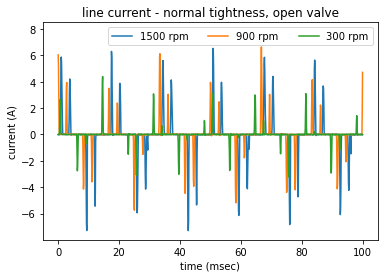

In [5]:
# plot raw data
# (3, 2, 13, 5, 9, 100000)

times = np.linspace(0, 100 - 0.1, 1000)

for rpmi in range(len(rpms) - 1, -1, -6):
    plt.plot(times, dat[1, 0, rpmi, 0, 0, :1000], label=f'{rpms[rpmi]} rpm')

plt.title('line current - normal tightness, open valve')
plt.ylim(top=8.5)
plt.xlabel('time (msec)')
plt.ylabel('current (A)')
plt.legend(ncol=3)

In [6]:
stds = dat.std(axis=-1)
print(f'stds.shape = {stds.shape}')
stds_avg = stds.mean(axis=3)
stds_std = stds.std(axis=3)
print(f'stds_avg.shape = {stds_avg.shape}')
print(f'stds_std.shape = {stds_std.shape}')

stds.shape = (3, 2, 13, 5, 9)
stds_avg.shape = (3, 2, 13, 9)
stds_std.shape = (3, 2, 13, 9)


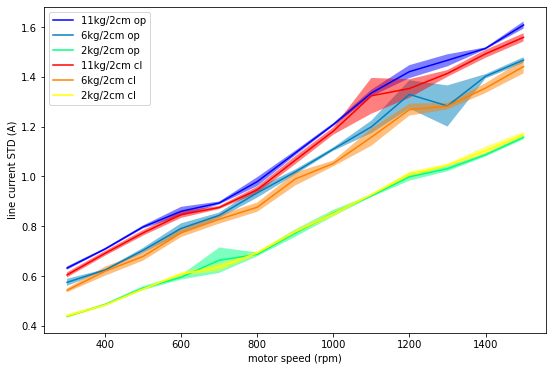

In [7]:
# plot STD

n_c = len(tights)
vlv_cs = [plt.cm.winter(np.linspace(0, 1, n_c)), plt.cm.autumn(np.linspace(0, 1, n_c))]

plt.figure(figsize=(9,6))
for vi in range(len(vlv)):
    n_c_i = 0
    for ti in range(len(tights)):
        Y = stds_avg[ti,vi,:,0]
        STD = stds_std[ti,vi,:,0]
        plt.fill_between(rpms, Y+STD, Y-STD, facecolor = vlv_cs[vi][n_c_i], alpha=0.5)
        plt.plot(rpms, Y, label=f'{tights[ti]}kg/2cm {vlv[vi]}', c=vlv_cs[vi][n_c_i])
        n_c_i += 1

plt.xlabel('motor speed (rpm)')
plt.ylabel('line current STD (A)')
plt.legend()

## Extract a single feature and train a model using its FFT w/o FracAvgPool

In [8]:
# sum1 = np.zeros_like(dat)
# sum2 = np.zeros_like(sum1)

# for T in range(dat.shape[-1]):
#     if T == 0:
#         sum1[:,:,:,:,:,0] = dat[:,:,:,:,:,0]
#         sum2[:,:,:,:,:,0] = dat[:,:,:,:,:,0] ** 2
#     else:
#         sum1[:,:,:,:,:,T] = sum1[:,:,:,:,:,T-1] + dat[:,:,:,:,:,T]
#         sum2[:,:,:,:,:,T] = sum2[:,:,:,:,:,T-1] + dat[:,:,:,:,:,T] ** 2

# window = 9381
# dat_movar = np.zeros_like(dat)
# for T in range(1, window):
#     dat_movar[:,:,:,:,:,T] = sum2[:,:,:,:,:,T] / T - (sum1[:,:,:,:,:,T] / T) ** 2
# for T in range(window,dat.shape[-1]):
#     dat_movar[:,:,:,:,:,T] = (sum2[:,:,:,:,:,T]-sum2[:,:,:,:,:,T-window]) / window 
#     - ((sum1[:,:,:,:,:,T]-sum1[:,:,:,:,:,T-window]) / window) ** 2

In [9]:
# for i in range(len(rpms)):
#     plt.plot(dat_movar[0,0,i,0,0], label=f'{i}')
# plt.legend()

In [81]:
# (3, 2, 13, 5, 9, 100000)
set_random_seed(0)

feat = 6                         # the feature
datalen = 2000                   # final length of one run; cut into different runs
cutn = dat.shape[-1] // datalen  # the number of slices in one run

input_size = datalen // 2        # input_size of encoder equals datalen // 2
latent_size = 2                  # because only the speed/valve/tightness are different
hidden_size = 500                # some reasonable value

train_ratio = 0.999              # train/validation ratio
batch_size = 500

# reshape the dataset
x_all = []
y_all = []
for t in range(0,len(tights)):
    for v in range(len(vlv)):
        for r in range(len(rpms)):
            for p in range(reps):
                y_all.append(np.array([[t, v, r]] * cutn))
                
                # fetch every continuous datalen points
                x_all.append(dat[t,v,r,p,feat,:datalen*cutn].reshape((cutn, datalen)))
#                 x_all.append(dat_movar[t,v,r,p,feat].reshape((cutn, datalen)))
                
                # fetch whole length but change sampling rate to a total of datalen points
#                 x_all.append(dat[t,v,r,p,feat,:datalen*cutn].reshape((datalen, cutn)).transpose())
                

x_all = np.concatenate(x_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# hack the input size
# input_size = 20

# perform FFT on x_all, and only retain the first half range, and absolute value
x_all_fft = np.abs(np.fft.fft(x_all,axis=-1))[:,:input_size]
# x_all_fft = x_all[:,:input_size]

# testx = x_all_fft.reshape((3, 2, 13, 5, 20, 2500))
# testx_avg = testx.mean(axis=-1)
# print(testx_avg[:,:,:,:,0])

# take the log
# x_all_fft = np.log(x_all_fft)

# divide by the largest value
x_all_fft /= x_all_fft.max()

print('x_all_fft.shape =', x_all_fft.shape)
print('y_all.shape =', y_all.shape)

# prepare dataset
train_size = int(len(x_all_fft)*train_ratio)
print('train_size =', train_size)

# convert to torch.Tensors
x_all_fft_t = torch.from_numpy(x_all_fft)
y_all_t = torch.from_numpy(y_all)

# pass through a sigmoid function to squeeze into [0, 1]
# x_all_fft_t = torch.sigmoid(x_all_fft_t)

# shuffle the sequence (x and y must still match)
seq = np.arange(len(x_all_fft))
np.random.shuffle(seq)
# x_all_fft_t = x_all_fft_t[seq]
# y_all_t = y_all_t[seq]

# dataset construction
train_dataset = TensorDataset(x_all_fft_t[seq[:train_size]], y_all_t[seq[:train_size]])
val_dataset = TensorDataset(x_all_fft_t[seq[train_size:]], y_all_t[seq[train_size:]])

# dataloader construction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

x_all_fft.shape = (19500, 1000)
y_all.shape = (19500, 3)
train_size = 19480


In [82]:
# testy = y_all.reshape()
testx = x_all_fft.reshape((3, 2, 13, 5, cutn, input_size))
testx_avg = testx.mean(axis=-1)

r=0, std=0.0006564379321400369
r=3, std=0.0008751917656525642
r=6, std=0.000946818389649399
r=9, std=0.0012581481026361716
r=12, std=0.001666339672004146


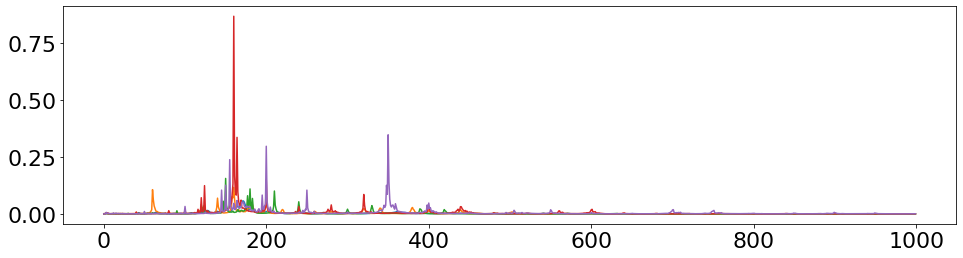

In [83]:
plt.figure(figsize=(16,4))
for r in range(0,13,3):
    stds = testx[0,:,:,:,:,:].std(axis=(0,2,3))[r][12]
    print(f'r={r}, std={stds}')
    plt.plot(testx[0,:,:,:,:,:].mean(axis=(0,2,3))[r])

# plt.plot(testx[0,0,-1,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-2,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-3,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-4,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-5,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-6,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-7,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-8,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-9,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-10,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-11,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-12,0,:,:20].mean(axis=0))
# plt.plot(testx[0,0,-13,0,:,:20].mean(axis=0))

In [84]:
# initialize VAE
lr = 1e-3

enc = vanilla_vae.Encoder(input_dim=input_size, hidden_dim=hidden_size, z_dim=latent_size).to(device)
dec = vanilla_vae.Decoder(z_dim=latent_size, hidden_dim=hidden_size, output_dim=input_size, output_bounded=True).to(device)
vae = vanilla_vae.VAE(enc, dec).to(device)

optim = torch.optim.Adam(vae.parameters(), lr=lr)
vae

VAE(
  (enc): Encoder(
    (fc): Sequential(
      (0): Linear(in_features=1000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=2, bias=True)
    (var): Linear(in_features=500, out_features=2, bias=True)
  )
  (dec): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): ReLU()
    )
    (out): Sequential(
      (0): Linear(in_features=500, out_features=1000, bias=True)
      (1): Sigmoid()
    )
  )
)

In [90]:
bchx = x_all_fft_t.to(device).float()
z_mu, z_var = vae.enc(bchx)

print(z_mu)

std = torch.exp(z_var / 2)
x_sample = torch.randn_like(std).mul(std).add_(z_mu)
pred = dec(z_mu)

F.mse_loss(pred, bchx)

tensor([[-2.4145,  1.1140],
        [-2.4835,  1.0376],
        [-2.3848,  1.1615],
        ...,
        [-6.5169, -0.8064],
        [-6.6854, -0.7553],
        [-6.5779, -0.6766]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor(1.8888e-05, device='cuda:0', grad_fn=<MseLossBackward0>)

Text(0, 0.5, 'mu[1]')

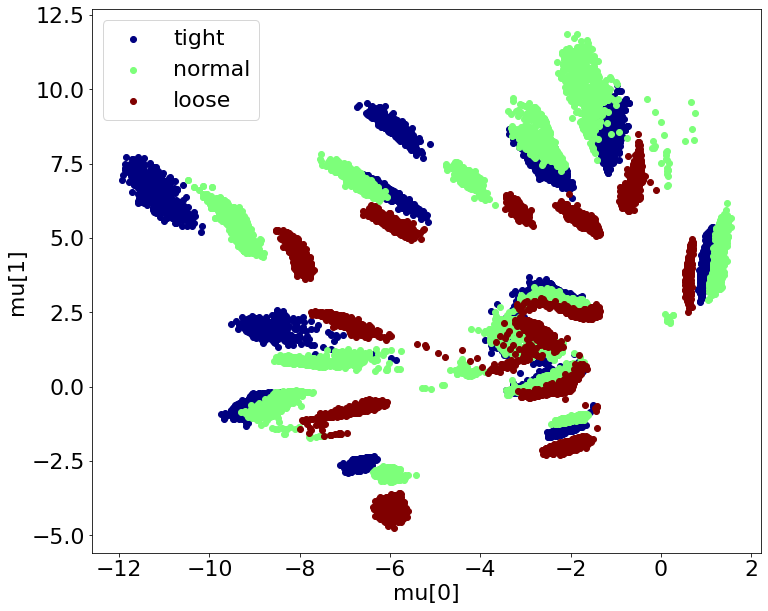

In [91]:
# plt.scatter()
# (1, 2, 13, reps, cutn)

n_c = len(tights)
cs = [plt.cm.winter(np.linspace(0, 1, n_c)), plt.cm.autumn(np.linspace(0, 1, n_c))]
cs = plt.cm.jet(np.linspace(0, 1, n_c))

plt.figure(figsize=(12,10))
matplotlib.rcParams.update({'font.size': 22})

tstr = ['tight','normal','loose']

mu = z_mu.cpu().detach().numpy().transpose()
var = z_var.cpu().detach().numpy().transpose()
stepn = reps * cutn
cnt = 0
for t in range(len(tights)):
    for v in range(len(vlv)):
        for r in range(len(rpms)):
            if v == 0 and r == 0:
                plt.scatter(mu[0,cnt:cnt+stepn], mu[1,cnt:cnt+stepn], color=cs[t], label=f'{tstr[t]}')
            else:
                plt.scatter(mu[0,cnt:cnt+stepn], mu[1,cnt:cnt+stepn], color=cs[t])
                
    #         plt.scatter(mu[0,cnt:cnt+stepn], mu[1,cnt:cnt+stepn], color=cs[v][r], alpha=0.5)
            cnt += stepn
plt.legend(ncol=1)
plt.xlabel('mu[0]')
plt.ylabel('mu[1]')

Text(0, 0.5, 'normalized current')

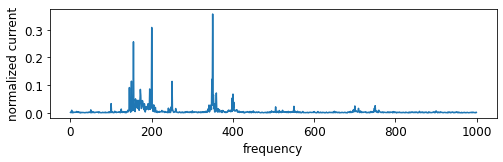

In [87]:
r = 12
i = r * reps * cutn

matplotlib.rcParams.update({'font.size': 12})
orgx = bchx[i].cpu().detach().numpy()
# predx = pred[i].cpu().detach().numpy()

plt.figure(figsize=(8,2))
plt.plot(orgx)
plt.xlabel('frequency')
plt.ylabel('normalized current')
# plt.plot(predx)

In [88]:
# training loop
# plt.figure(figsize=(12,10))

# optim.param_groups[0]['lr'] = 1e-5
epochs = 500
pbar = tqdm(range(epochs), colour='green')
for epoch in pbar:
    for batch_x, _ in train_dataloader:
        # to device and conversion
        batch_x_dev = batch_x.to(device).float()
        # forward pass
        predicted, z_mu, z_var = vae(batch_x_dev)
        # reconstruction loss
#         rec_loss = F.mse_loss(batch_x_dev, predicted)
        rec_loss = F.binary_cross_entropy(predicted, batch_x_dev, reduction='sum')        
        # KL divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        train_loss = rec_loss #+ kl_loss
        # update parameters
        optim.zero_grad()
        train_loss.backward()
        optim.step()
    
    desc = f'trn loss: rec={rec_loss.item():.8f} kl={kl_loss.item():.4f}; '
    
    with torch.no_grad():
        val_rec_loss = []
        val_kl_loss = []
        for batch_x, _ in val_dataloader:
            # to device and conversion
            batch_x_dev = batch_x.to(device).float()
            # forward pass
            predicted, z_mu, z_var = vae(batch_x_dev)
            # reconstruction loss
#             rec_loss = F.mse_loss(predicted, batch_x_dev)
            rec_loss = F.binary_cross_entropy(predicted, batch_x_dev, reduction='sum')
            # KL divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
            # append losses
            val_rec_loss.append(rec_loss.item())
            val_kl_loss.append(kl_loss.item())
        val_rec_loss = np.mean(val_rec_loss)
        val_kl_loss = np.mean(val_kl_loss)
    
    desc += f'val loss: rec={val_rec_loss:.8f} kl={val_kl_loss:.4f}'
    pbar.set_description(desc)
    
#     btchx = x_all_fft_t.to(device).float()
#     z_mu, _ = vae.enc(btchx)
#     mu = z_mu.cpu().detach().numpy().transpose()
#     stepn = reps * cutn
#     cnt = 0
#     plt.clf()
#     for v in range(len(vlv)):
#         for r in range(len(rpms)):
#             plt.scatter(mu[0,cnt:cnt+stepn], mu[1,cnt:cnt+stepn], color=cs[r])
#     #         plt.scatter(mu[0,cnt:cnt+stepn], mu[1,cnt:cnt+stepn], color=cs[v][r], alpha=0.5)
#             cnt += stepn
#     # plt.legend(ncol=1)
#     plt.title(f'epoch {epoch}')
#     plt.xlabel('mu[0]')
#     plt.ylabel('mu[1]')
#     plt.savefig(f'figs/{str(epoch).zfill(5)}.png')
    
#     z_mu, z_var = enc(batch_x_dev[:1])
#     std = torch.exp(z_var / 2)
#     eps = torch.randn_like(std)
#     x_sample = eps.mul(std).add_(z_mu)
#     d1.update(gen_img(image=batch_x_dev[:1]))
#     d2.update(gen_img(D=dec, latent=x_sample))
    

trn loss: rec=11304.03125000 kl=20238.3086; val loss: rec=483.85015869 kl=835.0644: 100%|██████| 500/500 [01:03<00:00,  7.86it/s]


In [ ]:
# best rec ~= 0.0001

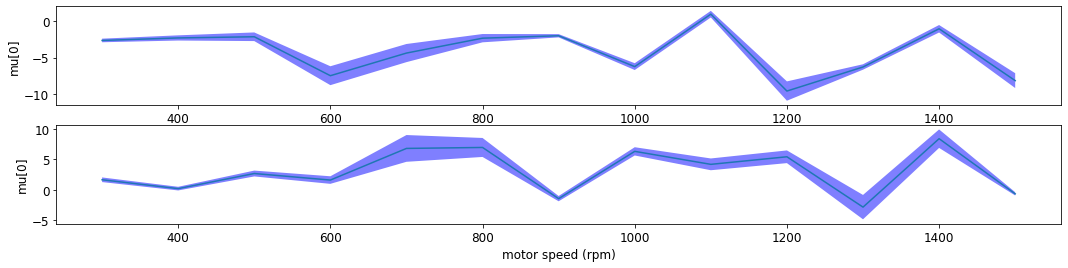

In [89]:
# check if the latent vectors have some relationship between tightness/valve/speed
latent_vs = []
bsize = 1
for bi in range(len(x_all_fft_t) // bsize):
    # retrieve batch
    batch_x = x_all_fft_t[bi*bsize:(bi+1)*bsize]
    # to device and conversion
    batch_x_dev = batch_x.to(device).float()
    # forward pass
    z_mu, _ = enc(batch_x_dev)
    # detach and append
    latent_vs.append(z_mu.cpu().detach().numpy())

latent_vs = np.concatenate(latent_vs, axis=0)

latent_tight = [[], [], []]
latent_valve = [[], []]
latent_speed = [[] for _ in range(len(rpms))]

for i in range(len(latent_vs)):
    latent_tight[y_all[i,0]].append(latent_vs[i])
    latent_valve[y_all[i,1]].append(latent_vs[i])
    latent_speed[y_all[i,2]].append(latent_vs[i])

latent_tight = np.array(latent_tight)
latent_valve = np.array(latent_valve)
latent_speed = np.array(latent_speed)

spd_mean = latent_speed.mean(axis=1)
spd_std = latent_speed.std(axis=1)

tgt_mean = latent_tight.mean(axis=1)
tgt_std = latent_tight.std(axis=1)

vlv_mean = latent_valve.mean(axis=1)
vlv_std = latent_valve.std(axis=1)

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(latent_size, 1, figsize=(18,4))

__mean = spd_mean
__std = spd_std
__x = rpms # np.arange(len(__mean))
for zi in range(latent_size):
    axs[zi].fill_between(__x, __mean[:,zi]+__std[:,zi], __mean[:,zi]-__std[:,zi], facecolor='blue', alpha=0.5)
    axs[zi].plot(__x, __mean[:,zi])
    axs[zi].set_ylabel('mu[0]')
    axs[zi].set_xlabel('motor speed (rpm)')